In [ ]:
import os
import math
import numpy as np
import torch
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

import torch.nn as nn
import torch.optim as optim

# 1. Data 전처리 function
### Data augmentation + Resize(224,224)
### Dataset
### DataLoader

In [ ]:
####################################################################
# Data Augmentation + Resize(224,224)
##############
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        size=(224, 224),
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

####################################################################
# Data Set
##############
from torch.utils.data import Dataset
class KittiDataset(Dataset):
    '''
    KittiDataset은 PyTorch의 Dataset을 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Dataset을 커스텀하여 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Dataset이 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해 kitti dataset의 경로에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        input_images = sorted(glob(os.path.join(self.dir_path, "image_2", "*.png")))
        label_images = sorted(glob(os.path.join(self.dir_path, "semantic", "*.png")))

        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Dataset의 length로서 전체 dataset 크기를 반환합니다.
        return len(self.data)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        input_img_path, output_path = self.data[index]

        _input = imread(input_img_path) #H,W,C
        _output = imread(output_path)

        # 특정 라벨을 이진 마스크로 변환
        _output = (_output == 7).astype(np.uint8) * 1

        data = {
            "image": _input,
            "mask": _output,
        }

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented["image"] / 255.0  # Normalize 0.0~1.0
            _output = augmented["mask"]

        # 📌 target 차원 확장 (H, W) → (1, H, W)
        _output = np.expand_dims(_output, axis=0)

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),  # (H, W, C) → (C, H, W)
            torch.tensor(_output, dtype=torch.float32)  # (1, H, W) 형식 유지
        )
    
####################################################################
# Data Loader
##############
from torch.utils.data import DataLoader

# Augmentation 설정
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_dataset = KittiDataset(
    data_dir,
    augmentation=augmentation,
    is_train=True
)

test_dataset = KittiDataset(
    data_dir,
    augmentation=test_preproc,
    is_train=False
)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 2. 결과 확인 function
### calculate_iou_score
### get_output

In [ ]:
def calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    iou_score = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print(f"IoU : {iou_score:.6f}")
    return iou_score


def get_output(model, preproc, image_path, output_path, label_path=None):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)
    input_tensor.to('cuda:0') #입력을 GPU 0으로 보냄

    model.eval()
    with torch.no_grad():
        output = model(input_tensor) #(내부에서 GPU 0 -> GPU 1 이동 일어남)
    #결과는 GPU 1에 있음 -> CPU로 가져오기
    prediction = (output[0].cpu().squeeze().numpy() > 0.5).astype(np.uint8) * 255
    prediction = Image.fromarray(prediction).convert('L')

    background = Image.fromarray(origin_img).convert('RGBA')
    prediction_resized = prediction.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, prediction_resized, alpha=0.5)

    blended.save(output_path)
    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(background)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    target = None
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)["image"]
        target = (label_processed == 7).astype(np.uint8) * 1

        target_resized = (label_processed == 7).astype(np.uint8) * 255
        target_resized = Image.fromarray(target_resized).convert('L')
        target_resized = target_resized.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
        blended_target = Image.blend(background, target_resized, alpha=0.5)
        blended_target_np = np.array(blended_target)
        plt.imshow(blended_target_np)
        plt.axis('off')  # 축 제거 (옵션)
        plt.show()

    return blended, np.array(prediction), target

# $\color{red}{3. UNet}$ (padding, BCE loss)
##### 3.1 Model(UNet)
##### 3.2 학습(UNet)
##### 3.3 결과확인(UNet)

### 3.1 Model(UNet)

In [ ]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc1 = self.double_conv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        self.dropout = nn.Dropout(0.5)

        # Expanding Path (Decoder)
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec9 = self.double_conv(128, 64)

        # Output layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """2개의 Conv Layer로 이루어진 블록"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        c4 = self.enc4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.bottleneck(p4)
        c5 = self.dropout(c5)

        # Decoder
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.dec6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.dec7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.dec8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.dec9(u9)

        # Output
        output = torch.sigmoid(self.final(c9))
        return output

### 3.2 학습(UNet)

In [ ]:
import time

# [설정] Early Stopping 관련 파라미터
patience = 50       # 성능이 개선되지 않아도 참을 Epoch 수
counter = 0         # 현재 성능 개선이 안 된 횟수
best_val_loss = float('inf') # 최적의 Validation Loss (초기값: 무한대)

# 모델 저장 경로
model_path = "./seg_model_unet.pth"

# 모델 생성
model = UNet(input_channels=3, output_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 400
for epoch in range(num_epochs):
    start_time = time.time()
    # -----------------------
    # 1. Training Loop
    # -----------------------
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    #--------------------------------------------------
    # -----------------------
    # 2. Validation Loop
    # -----------------------
    model.eval() # 평가 모드로 전환 (Dropout, BatchNorm 등 고정)
    val_loss = 0.0
    
    with torch.no_grad(): # Gradient 계산 비활성화 (메모리 절약 및 속도 향상)
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
                
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)

    #-----------------------------------------------------
    end_time = time.time()
    elapsed_time = end_time - start_time

    # 성능 개선 여부 확인, 모델 저장
    if avg_val_loss < best_val_loss:
        counter = 0  # 카운터 초기화
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path) # 모델 저장
        #print(f" --> Best Model Saved! (Loss: {best_val_loss:.6f})")
    else:
        counter += 1 # 카운터 증가
        if ((counter >= patience) and (epoch > 100)):
            print("\n[Early Stopping] 학습을 조기 종료합니다.")
            break

    print(f"Epoch {epoch+1:3d}/{num_epochs:3d} | "
          f"Train Loss: {avg_train_loss:.6f} | "
          f"Valid Loss: {avg_val_loss:.6f} | "
          f"Time: {elapsed_time:5.2f}s | "
          f"Best val loss: {best_val_loss:.6f}")


Epoch   1/400 | Train Loss: 0.710828 | Valid Loss: 0.696666 | Time:  9.85s | Best val loss: 0.696666
Epoch   2/400 | Train Loss: 0.663680 | Valid Loss: 0.583180 | Time:  9.67s | Best val loss: 0.583180
Epoch   3/400 | Train Loss: 0.580150 | Valid Loss: 0.549235 | Time:  9.91s | Best val loss: 0.549235
Epoch   4/400 | Train Loss: 0.494832 | Valid Loss: 0.463070 | Time: 10.02s | Best val loss: 0.463070
Epoch   5/400 | Train Loss: 0.423607 | Valid Loss: 0.383508 | Time:  9.84s | Best val loss: 0.383508
Epoch   6/400 | Train Loss: 0.357302 | Valid Loss: 0.364620 | Time:  9.66s | Best val loss: 0.364620
Epoch   7/400 | Train Loss: 0.339620 | Valid Loss: 0.349927 | Time:  9.61s | Best val loss: 0.349927
Epoch   8/400 | Train Loss: 0.308582 | Valid Loss: 0.348629 | Time:  9.69s | Best val loss: 0.348629
Epoch   9/400 | Train Loss: 0.298344 | Valid Loss: 0.348129 | Time:  9.71s | Best val loss: 0.348129
Epoch  10/400 | Train Loss: 0.273663 | Valid Loss: 0.254505 | Time:  9.73s | Best val loss:

### 3.3 결과확인(UNet)

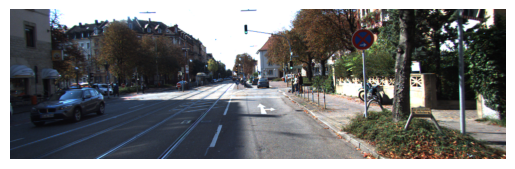

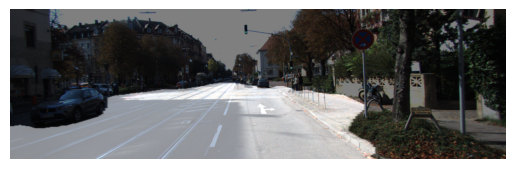

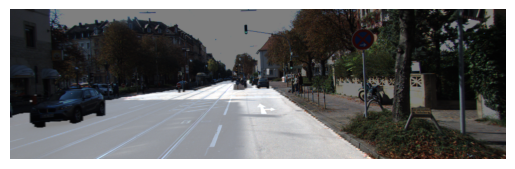

IoU : 0.847088


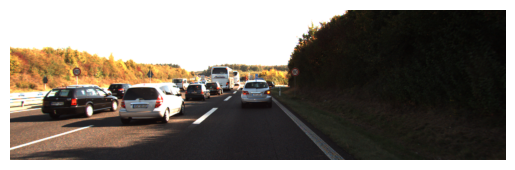

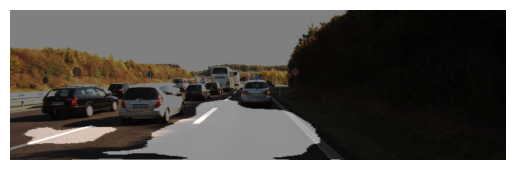

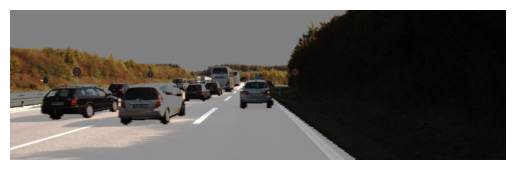

IoU : 0.554367


In [ ]:
# 모델 저장 경로
model_path = "./seg_model_unet.pth"

# 모델 생성
model = UNet(input_channels=3, output_channels=1)
model.load_state_dict(torch.load(model_path))
model.eval()  # 평가 모드로 전환

# 시각화, IoU
for i in [1,199]:
    output, prediction, target = get_output(
         model,
         test_preproc,
         image_path=data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=data_dir + f'/result_{str(i).zfill(3)}.png',
         label_path=data_dir + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    
    calculate_iou_score(target, prediction)

# $\color{red}{4. UNet++}$ (BCE loss + Dice loss)
##### 4.1 Model(UNet++) - Muti-GPU 사용
##### 4.2 Loss(UNet++, BCE loss + Dice loss)
##### 4.3 학습(UNet++)
##### 4.4 결과확인(UNet++)

### 4.1 Model(UNet++) (Muti-GPU 사용)

In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
from layers import unetConv2, unetUp_origin
from init_weights import init_weights
import numpy as np
from torchvision import models

class UNet_2Plus(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True, is_ds=False, training=False):
        super(UNet_2Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.is_ds = is_ds
        self.feature_scale = feature_scale
        self.training = training

        # GPU 디바이스 지정 (코드 가독성을 위해)
        self.dev0 = torch.device('cuda:0') # 2080Ti
        self.dev1 = torch.device('cuda:1') # 1080Ti

        filters = [64, 128, 256, 512, 1024]
        # filters = [int(x / self.feature_scale) for x in filters]

        # --------------------------------------------------------
        # [GPU 0 할당] Downsampling (Encoder)
        # --------------------------------------------------------
        self.conv00 = unetConv2(self.in_channels, filters[0], self.is_batchnorm).to(self.dev0)
        self.maxpool0 = nn.MaxPool2d(kernel_size=2).to(self.dev0)
        self.conv10 = unetConv2(filters[0], filters[1], self.is_batchnorm).to(self.dev0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2).to(self.dev0)
        self.conv20 = unetConv2(filters[1], filters[2], self.is_batchnorm).to(self.dev0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2).to(self.dev0)
        self.conv30 = unetConv2(filters[2], filters[3], self.is_batchnorm).to(self.dev0)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2).to(self.dev0)
        self.conv40 = unetConv2(filters[3], filters[4], self.is_batchnorm).to(self.dev0)

        # --------------------------------------------------------
        # [GPU 1 할당] Upsampling (Decoder) & Final Layers
        # --------------------------------------------------------
        self.up_concat01 = unetUp_origin(filters[1], filters[0], self.is_deconv).to(self.dev1)
        self.up_concat11 = unetUp_origin(filters[2], filters[1], self.is_deconv).to(self.dev1)
        self.up_concat21 = unetUp_origin(filters[3], filters[2], self.is_deconv).to(self.dev1)
        self.up_concat31 = unetUp_origin(filters[4], filters[3], self.is_deconv).to(self.dev1)

        self.up_concat02 = unetUp_origin(filters[1], filters[0], self.is_deconv, 3).to(self.dev1)
        self.up_concat12 = unetUp_origin(filters[2], filters[1], self.is_deconv, 3).to(self.dev1)
        self.up_concat22 = unetUp_origin(filters[3], filters[2], self.is_deconv, 3).to(self.dev1)

        self.up_concat03 = unetUp_origin(filters[1], filters[0], self.is_deconv, 4).to(self.dev1)
        self.up_concat13 = unetUp_origin(filters[2], filters[1], self.is_deconv, 4).to(self.dev1)

        self.up_concat04 = unetUp_origin(filters[1], filters[0], self.is_deconv, 5).to(self.dev1)

        # final conv (without any concat)
        self.final_1 = nn.Conv2d(filters[0], n_classes, 1).to(self.dev1)
        self.final_2 = nn.Conv2d(filters[0], n_classes, 1).to(self.dev1)
        self.final_3 = nn.Conv2d(filters[0], n_classes, 1).to(self.dev1)
        self.final_4 = nn.Conv2d(filters[0], n_classes, 1).to(self.dev1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # ------------------------------------------------
        # [Step 1] GPU 0에서 인코더 연산 수행
        # ------------------------------------------------
        # 입력 데이터가 0번 GPU에 있는지 확인 (보통 DataLoader에서 보낼 때 주의)
        inputs = inputs.to(self.dev0) 

        # column : 0 (Encoder)
        X_00 = self.conv00(inputs)
        maxpool0 = self.maxpool0(X_00)
        X_10 = self.conv10(maxpool0)
        maxpool1 = self.maxpool1(X_10)
        X_20 = self.conv20(maxpool1)
        maxpool2 = self.maxpool2(X_20)
        X_30 = self.conv30(maxpool2)
        maxpool3 = self.maxpool3(X_30)
        X_40 = self.conv40(maxpool3)

        # ------------------------------------------------
        # [Step 2] 데이터 이동 (GPU 0 -> GPU 1)
        # ------------------------------------------------
        # Decoder 연산을 위해 인코더에서 나온 특징맵들을 GPU 1로 복사합니다.
        # 이렇게 변수명을 따로 지정해주면 중복 전송을 막고 가독성이 좋아집니다.
        X_00_d = X_00.to(self.dev1)
        X_10_d = X_10.to(self.dev1)
        X_20_d = X_20.to(self.dev1)
        X_30_d = X_30.to(self.dev1)
        X_40_d = X_40.to(self.dev1)

        # ------------------------------------------------
        # [Step 3] GPU 1에서 디코더 연산 수행
        # ------------------------------------------------
        # 모든 입력값은 _d (GPU 1에 있는 텐서)를 사용해야 합니다.
        
        # column : 1
        X_01 = self.up_concat01(X_10_d, X_00_d)
        X_11 = self.up_concat11(X_20_d, X_10_d)
        X_21 = self.up_concat21(X_30_d, X_20_d)
        X_31 = self.up_concat31(X_40_d, X_30_d)
        
        # column : 2
        X_02 = self.up_concat02(X_11, X_00_d, X_01)
        X_12 = self.up_concat12(X_21, X_10_d, X_11)
        X_22 = self.up_concat22(X_31, X_20_d, X_21)
        
        # column : 3
        X_03 = self.up_concat03(X_12, X_00_d, X_01, X_02)
        X_13 = self.up_concat13(X_22, X_10_d, X_11, X_12)
        
        # column : 4
        X_04 = self.up_concat04(X_13, X_00_d, X_01, X_02, X_03)

        # final layer
        final_1 = self.final_1(X_01)
        final_2 = self.final_2(X_02)
        final_3 = self.final_3(X_03)
        final_4 = self.final_4(X_04)

        # final = (final_1 + final_2 + final_3 + final_4) / 4
        # if self.is_ds:
        #     return F.sigmoid(final)
        # else:
        #     return F.sigmoid(final_4)


        # 학습 중이고 is_ds가 켜져있다면, 4개를 따로따로 리턴합니다.
        if self.is_ds and self.training: 
            return [F.sigmoid(final_1), F.sigmoid(final_2), F.sigmoid(final_3), F.sigmoid(final_4)]
        
        # 추론(테스트) 중일 때는 앙상블(평균) 결과를 리턴합니다. (성능 극대화)
        final = (final_1 + final_2 + final_3 + final_4) / 4
        if self.is_ds:
            return F.sigmoid(final)
        else:
            return F.sigmoid(final_4)

### 4.2 Loss(UNet++, BCE loss + Dice loss)

In [ ]:
import torch
import torch.nn.functional as F

def calc_loss(pred, target, bce_weight=0.5):
    # 1. BCE Loss 계산
    bce = F.binary_cross_entropy(pred, target)
    
    # 2. Dice Loss 계산
    smooth = 1e-5
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    dice_loss = 1 - dice
    
    # 3. 두 Loss 합산
    loss = bce * bce_weight + dice_loss * (1 - bce_weight)
    return loss

### 4.3 학습(UNet++)

In [ ]:
import time

# [설정] Early Stopping 관련 파라미터
patience = 50       # 성능이 개선되지 않아도 참을 Epoch 수
counter = 0         # 현재 성능 개선이 안 된 횟수
best_val_loss = float('inf') # 최적의 Validation Loss (초기값: 무한대)

# 모델 저장 경로
model_path = "./seg_model_unetPP.pth"

# 모델 생성
model = UNet_2Plus(in_channels=3, n_classes=1, is_ds=True, training=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 400
for epoch in range(num_epochs):
    start_time = time.time()

    # -----------------------
    # 1. Training Loop
    # -----------------------
    model.train()
    model.training=True
    model.is_ds=True
    train_loss = 0.0
    for inputs, targets in train_loader:
        #inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.to('cuda:0'), targets.to('cuda:1')

        optimizer.zero_grad()
        outputs = model(inputs)
        #loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
        if model.is_ds and model.training:
            # 리스트로 나오므로 각각 Loss 계산 후 합산
            loss = 0
            for output in outputs:
                loss += calc_loss(output, targets)
            loss /= len(outputs) # 혹은 가중치 적용
        else:
            # 하나만 나오므로 그냥 계산
            loss = calc_loss(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    #--------------------------------------------------
    # -----------------------
    # 2. Validation Loop
    # -----------------------
    model.eval() # 평가 모드로 전환 (Dropout, BatchNorm 등 고정)
    model.training=False
    model.is_ds=False
    val_loss = 0.0
    
    with torch.no_grad(): # Gradient 계산 비활성화 (메모리 절약 및 속도 향상)
        for inputs, targets in test_loader:
            inputs, targets = inputs.to('cuda:0'), targets.to('cuda:1')
            
            outputs = model(inputs)
            
            # eval 모드에서는 일반적으로 Deep Supervision 리스트가 아닌 최종 결과만 나오거나,
            # 모델 구조에 따라 로직이 달라질 수 있습니다.
            # 작성하신 코드의 if model.is_ds and model.training 조건에 따라
            # model.eval() 상태에서는 else문(단일 출력)으로 처리됩니다.
            # if isinstance(outputs, list): # 만약 eval에서도 리스트로 나온다면
            #      # 보통 검증때는 마지막 레이어(가장 정교한 출력)만 사용하여 loss 계산
            #     loss = calc_loss(outputs[0], targets) 
            # else:
            #     loss = calc_loss(outputs, targets)
            loss = calc_loss(outputs, targets)
                
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)

    #-----------------------------------------------------
    end_time = time.time()
    elapsed_time = end_time - start_time

    # 성능 개선 여부 확인, 모델 저장
    if avg_val_loss < best_val_loss:
        counter = 0  # 카운터 초기화
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path) # 모델 저장
        #print(f" --> Best Model Saved! (Loss: {best_val_loss:.6f})")
    else:
        counter += 1 # 카운터 증가
        if ((counter >= patience) and (epoch > 100)):
            print("\n[Early Stopping] 학습을 조기 종료합니다.")
            break

    print(f"Epoch {epoch+1:3d}/{num_epochs:3d} | "
          f"Train Loss: {avg_train_loss:.6f} | "
          f"Valid Loss: {avg_val_loss:.6f} | "
          f"Time: {elapsed_time:5.2f}s | "
          f"Best val loss: {best_val_loss:.6f}")

Epoch   1/400 | Train Loss: 0.522430 | Valid Loss: 0.568925 | Time: 22.26s | Best val loss: 0.568925
Epoch   2/400 | Train Loss: 0.330255 | Valid Loss: 0.437053 | Time: 22.30s | Best val loss: 0.437053
Epoch   3/400 | Train Loss: 0.263704 | Valid Loss: 0.235040 | Time: 21.75s | Best val loss: 0.235040
Epoch   4/400 | Train Loss: 0.257380 | Valid Loss: 0.274930 | Time: 22.12s | Best val loss: 0.235040
Epoch   5/400 | Train Loss: 0.222459 | Valid Loss: 0.306444 | Time: 22.00s | Best val loss: 0.235040
Epoch   6/400 | Train Loss: 0.227275 | Valid Loss: 0.261454 | Time: 22.49s | Best val loss: 0.235040
Epoch   7/400 | Train Loss: 0.217661 | Valid Loss: 0.266000 | Time: 21.29s | Best val loss: 0.235040
Epoch   8/400 | Train Loss: 0.206407 | Valid Loss: 0.260528 | Time: 21.79s | Best val loss: 0.235040
Epoch   9/400 | Train Loss: 0.199835 | Valid Loss: 0.275826 | Time: 22.95s | Best val loss: 0.235040
Epoch  10/400 | Train Loss: 0.215323 | Valid Loss: 0.243447 | Time: 21.27s | Best val loss:

### 4.4 결과확인(UNet++)

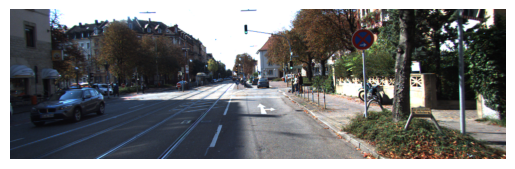

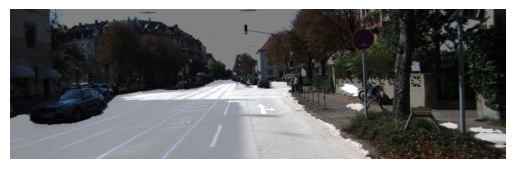

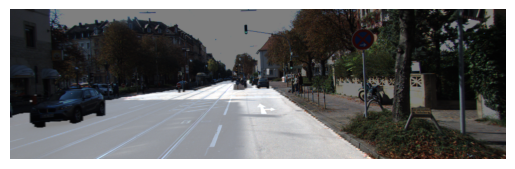

IoU : 0.910760


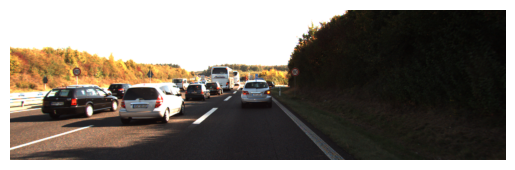

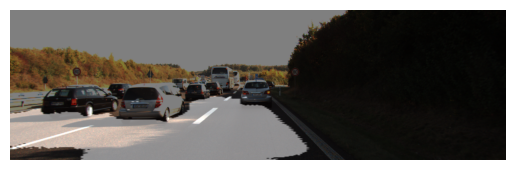

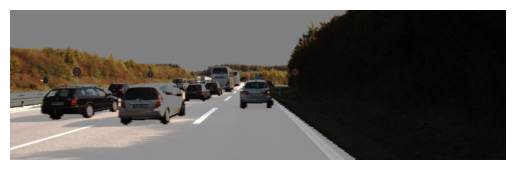

IoU : 0.784258


In [ ]:
# 모델 저장 경로
model_path = "./seg_model_unetPP.pth"

# 모델 생성
model = UNet_2Plus(in_channels=3, n_classes=1, is_ds=False, training=False)
model.load_state_dict(torch.load(model_path))
model.eval()  # 평가 모드로 전환

# 시각화, IoU
for i in [1,199]:
    output, prediction, target = get_output(
         model,
         test_preproc,
         image_path=data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=data_dir + f'/result_{str(i).zfill(3)}.png',
         label_path=data_dir + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    
    calculate_iou_score(target, prediction)

# $\color{red}{5. UNet++}$ (Dice loss + Boundary IoU loss)
##### 5.1 Loss(UNet++, Dice loss + Boundary IoU loss)
##### 5.2 학습(UNet++)
##### 5.3 결과확인(UNet++)

### 5.1 Loss(UNet++, Dice loss + Boundary IoU loss)

In [8]:
import torch
import torch.nn.functional as F

def calc_loss(pred, target, dice_weight=0.4):
    """
    pred: 모델의 예측값 (Sigmoid 적용된 0~1 사이 확률값, Shape: [B, C, H, W])
    target: 정답 마스크 (0 또는 1, Shape: [B, C, H, W])
    dice_weight: Dice Loss의 비중 (기본 0.5, 나머지는 Boundary Loss)
    """
    
    # --------------------------------------------
    # 1. Dice Loss Part
    # --------------------------------------------
    smooth = 1e-5
    # 전체 배치를 하나로 보고 계산 (Global Dice) - 기존 코드 스타일 유지
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    dice_loss = 1 - dice
    
    # --------------------------------------------
    # 2. Boundary IoU Loss Part
    # --------------------------------------------
    # MaxPool2d를 사용하여 Dilation(팽창)과 Erosion(침식)을 시뮬레이션합니다.
    # 경계선 = 팽창된 영역 - 침식된 영역
    
    # Kernel Size 3은 3x3 영역을 보겠다는 의미입니다.
    pred_dilated = F.max_pool2d(pred, kernel_size=3, stride=1, padding=1)
    pred_eroded = -F.max_pool2d(-pred, kernel_size=3, stride=1, padding=1) # 음수로 변환 후 MaxPool = MinPool(Erosion)
    pred_boundary = pred_dilated - pred_eroded
    
    target_dilated = F.max_pool2d(target, kernel_size=3, stride=1, padding=1)
    target_eroded = -F.max_pool2d(-target, kernel_size=3, stride=1, padding=1)
    target_boundary = target_dilated - target_eroded
    
    # 경계선끼리의 IoU 계산
    bound_inter = (pred_boundary * target_boundary).sum()
    bound_union = pred_boundary.sum() + target_boundary.sum() - bound_inter
    
    boundary_loss = 1 - (bound_inter + smooth) / (bound_union + smooth)
    
    # --------------------------------------------
    # 3. Final Combined Loss
    # --------------------------------------------
    # 두 Loss를 가중 합산합니다.
    total_loss = dice_weight * dice_loss + (1 - dice_weight) * boundary_loss
    
    return total_loss

### 5.2 학습(UNet++)

In [9]:
import time

# [설정] Early Stopping 관련 파라미터
patience = 50       # 성능이 개선되지 않아도 참을 Epoch 수
counter = 0         # 현재 성능 개선이 안 된 횟수
best_val_loss = float('inf') # 최적의 Validation Loss (초기값: 무한대)

# 모델 저장 경로
model_path = "./seg_model_unetPP_boundary.pth"

# 모델 생성
model = UNet_2Plus(in_channels=3, n_classes=1, is_ds=True, training=True)
model.load_state_dict(torch.load(model_path))


# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 400
for epoch in range(num_epochs):
    start_time = time.time()

    # -----------------------
    # 1. Training Loop
    # -----------------------
    model.train()
    model.training=True
    model.is_ds=True
    train_loss = 0.0
    for inputs, targets in train_loader:
        #inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.to('cuda:0'), targets.to('cuda:1')

        optimizer.zero_grad()
        outputs = model(inputs)
        #loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
        if model.is_ds and model.training:
            # 리스트로 나오므로 각각 Loss 계산 후 합산
            loss = 0
            for output in outputs:
                loss += calc_loss(output, targets)
            loss /= len(outputs) # 혹은 가중치 적용
        else:
            # 하나만 나오므로 그냥 계산
            loss = calc_loss(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    #--------------------------------------------------
    # -----------------------
    # 2. Validation Loop
    # -----------------------
    model.eval() # 평가 모드로 전환 (Dropout, BatchNorm 등 고정)
    model.training=False
    model.is_ds=False
    val_loss = 0.0
    
    with torch.no_grad(): # Gradient 계산 비활성화 (메모리 절약 및 속도 향상)
        for inputs, targets in test_loader:
            inputs, targets = inputs.to('cuda:0'), targets.to('cuda:1')
            
            outputs = model(inputs)
            
            # eval 모드에서는 일반적으로 Deep Supervision 리스트가 아닌 최종 결과만 나오거나,
            # 모델 구조에 따라 로직이 달라질 수 있습니다.
            # 작성하신 코드의 if model.is_ds and model.training 조건에 따라
            # model.eval() 상태에서는 else문(단일 출력)으로 처리됩니다.
            # if isinstance(outputs, list): # 만약 eval에서도 리스트로 나온다면
            #      # 보통 검증때는 마지막 레이어(가장 정교한 출력)만 사용하여 loss 계산
            #     loss = calc_loss(outputs[0], targets) 
            # else:
            #     loss = calc_loss(outputs, targets)
            loss = calc_loss(outputs, targets)
                
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)

    #-----------------------------------------------------
    end_time = time.time()
    elapsed_time = end_time - start_time

    # 성능 개선 여부 확인, 모델 저장
    if avg_val_loss < best_val_loss:
        counter = 0  # 카운터 초기화
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path) # 모델 저장
        #print(f" --> Best Model Saved! (Loss: {best_val_loss:.6f})")
    else:
        counter += 1 # 카운터 증가
        if (counter >= patience):#((counter >= patience) and (epoch > 100)):
            print("\n[Early Stopping] 학습을 조기 종료합니다.")
            break

    print(f"Epoch {epoch+1:3d}/{num_epochs:3d} | "
          f"Train Loss: {avg_train_loss:.6f} | "
          f"Valid Loss: {avg_val_loss:.6f} | "
          f"Time: {elapsed_time:5.2f}s | "
          f"Best val loss: {best_val_loss:.6f}")

Epoch   1/400 | Train Loss: 0.581771 | Valid Loss: 0.575508 | Time: 22.87s | Best val loss: 0.575508
Epoch   2/400 | Train Loss: 0.554439 | Valid Loss: 0.540228 | Time: 21.42s | Best val loss: 0.540228
Epoch   3/400 | Train Loss: 0.538933 | Valid Loss: 0.533821 | Time: 21.81s | Best val loss: 0.533821
Epoch   4/400 | Train Loss: 0.529082 | Valid Loss: 0.571485 | Time: 22.25s | Best val loss: 0.533821
Epoch   5/400 | Train Loss: 0.533712 | Valid Loss: 0.535973 | Time: 21.89s | Best val loss: 0.533821
Epoch   6/400 | Train Loss: 0.528640 | Valid Loss: 0.520229 | Time: 22.18s | Best val loss: 0.520229
Epoch   7/400 | Train Loss: 0.517409 | Valid Loss: 0.528753 | Time: 22.17s | Best val loss: 0.520229
Epoch   8/400 | Train Loss: 0.512624 | Valid Loss: 0.522918 | Time: 21.86s | Best val loss: 0.520229
Epoch   9/400 | Train Loss: 0.503706 | Valid Loss: 0.510954 | Time: 21.94s | Best val loss: 0.510954
Epoch  10/400 | Train Loss: 0.506809 | Valid Loss: 0.543852 | Time: 20.44s | Best val loss:

### 5.3 결과확인(UNet++)

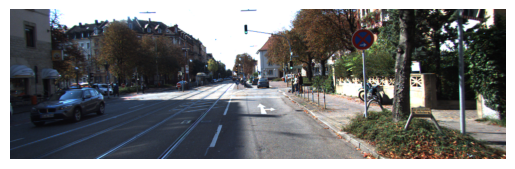

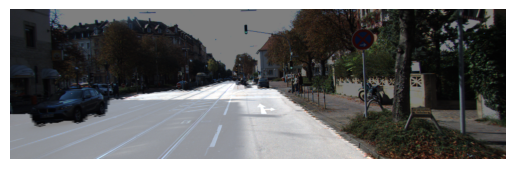

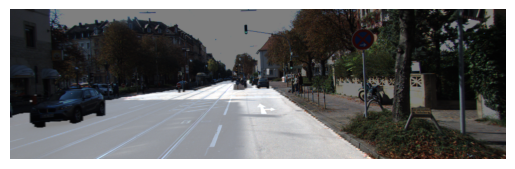

IoU : 0.973603


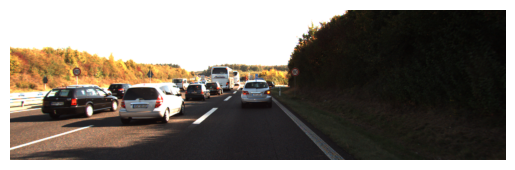

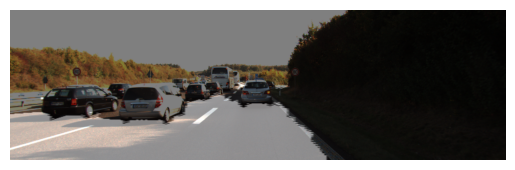

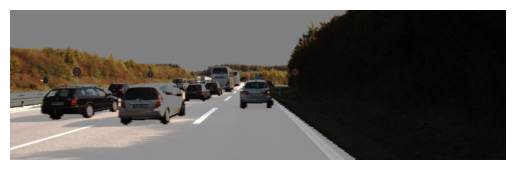

IoU : 0.898556


In [ ]:
# 모델 저장 경로
model_path = "./seg_model_unetPP_boundary.pth"

# 모델 생성
model = UNet_2Plus(in_channels=3, n_classes=1, is_ds=False, training=False)
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_path))
model.eval()  # 평가 모드로 전환

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
for i in [1,199]:
    output, prediction, target = get_output(
         model,
         test_preproc,
         image_path=data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=data_dir + f'/result_{str(i).zfill(3)}.png',
         label_path=data_dir + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    
    calculate_iou_score(target, prediction)

# $\color{red}{6. 분석  및  고찰}$

시간관계상 짧게만 분석 결과를 남긴다.  
<br>
1. 각 학습의 수렴 확인<br>
각 학습은 안정적으로 수렴했으나 과적합 경향을 보인다. (Train, Valid data set 둘 다 부족)  
마지막 모델에서 Boundary IoU loss는 특성상 학습 초반에는 객체의 위치를 못찾을 가능성이 크므로  
학습 초반에는 Dice loss에 weight를 더 주고,  
학습 후반으로 가면서 Boundary IoU loss의 weight를 늘려 가능 방법을 사용할 수 있는데,  
여기서는 앞선 모델에서 학습된 weight를 불러와서 활용하였다.  
앞선 모델에서 객체의 위치는 충분히 잘 학습되었으므로, 경계선을 확실히 구분하기 위해  
Dice loss와 Boundary IoU loss의 ratio는 40:60을 사용하였다.  
<img src='loss.png' width='700'><br>
<br>
2. UNet VS UNet++(BCE+Dice loss) VS UNet++(Dice+Boundary IoU loss)<br>
Unet을 사용하였을대 보다 UNet++ 구조를 사용하였을 때, 보다 나은 성능을 보인다.
(BCE+Dice loss)보다 (Dice+Boundary IoU loss)를 사용하였을 때, 보다 나은 성능을 보인다.  
<br>
     a. 정량적 성능 평가(IoU)<br>
         - UNet++(Dice+Boundary IoU loss) > UNet++(BCE+Dice loss) > UNet  
         - 0.8470 > 0.9107 > 0.9736  
         - 0.5543 > 0.7842 > 0.8985  
<br>
     b. 정성적 평가(결과 이미지 확인)<br>
         - UNet++(Dice+Boundary IoU loss) > UNet++(BCE+Dice loss) > UNet  
         - segmentation 하는 면적, 경계선 부분에서 보다 나은 성능을 보임  
         - 인도, 경계석, 차량 경계, 그림자 등에서 보다 나은 성능을 보임  
<img src='result.png' width='700'><br>
